# BTC Predictor

In [188]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [189]:
import json as js
import numpy as np
import pandas as pd
from ta import *


class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_test_train(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        test_records_count = int(len(self.train) * (1-percent_split))
        self.test = self.train.tail(test_records_count)
        self.train = self.train.head(train_records_count)
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close, weighted_price):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close],
            'Weighted_Price': self.train[weighted_price]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close', 'Weighted_Price']]

    def clean_train(self):
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    """ Trim the beginning to have accurate TA values, trim the end to have accurate target value"""

    def trim_ends(self, begin_count, end_count):
        self.train = self.train.iloc[begin_count:]
        self.train = self.train.iloc[:-end_count]
        print('Trim beginning: ' + str(begin_count) + '. Trim end: ' +
              str(end_count) + '. Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # ////// FEATURE CREATION ///////
    # ///////////////////////////////

    def get_train_size(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        print('Train size: ' + str(train_records_count) +
              ' percent_split: ' + str(percent_split))
        return train_records_count

    def get_validation_indexes(self, train_size, df):
        validation_indexes = list(range(train_size, len(df)))
        print('Validation Index size: ' + str(len(validation_indexes)))
        return validation_indexes

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_min_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).min()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def get_max_lookahead(self, df, target, lookahead):
        return df[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]

    def get_last_lookahead(self, df, target, lookahead):
        return df[target].shift(-lookahead)

    def get_lookback(self, df, target, lookback):
        return df[target].shift(lookback)

    def add_historical_candles(self, df, lookback):
        for i in range(1, lookback):
            df[str(i) + 'Open'] = self.get_lookback(df, 'Open', i)
            df[str(i) + 'High'] = self.get_lookback(df, 'High', i)
            df[str(i) + 'Low'] = self.get_lookback(df, 'Low', i)
            df[str(i) + 'Close'] = self.get_lookback(df, 'Close', i)
            df[str(i) + 'Volume'] = self.get_lookback(df, 'Volume', i)

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['maxc5'] = self.get_max_lookback("Close", 5)
        self.train['maxc15'] = self.get_max_lookback("Close", 15)
        self.train['maxc30'] = self.get_max_lookback("Close", 30)
        self.train['maxc60'] = self.get_max_lookback("Close", 60)
        self.train['maxc90'] = self.get_max_lookback("Close", 90)
        self.train['maxh5'] = self.get_max_lookback("High", 5)
        self.train['maxh15'] = self.get_max_lookback("High", 15)
        self.train['maxh30'] = self.get_max_lookback("High", 30)
        self.train['maxh60'] = self.get_max_lookback("High", 60)
        self.train['maxh90'] = self.get_max_lookback("High", 90)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        self.train['minc5'] = self.get_min_lookback("Close", 5)
        self.train['minc15'] = self.get_min_lookback("Close", 15)
        self.train['minc30'] = self.get_min_lookback("Close", 30)
        self.train['minc60'] = self.get_min_lookback("Close", 60)
        self.train['minc90'] = self.get_min_lookback("Close", 90)
        self.add_historical_candles(self.train, 30)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease):
        self.train['action'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train.loc[max_lookahead > self.train['Close'], 'action'] = 1
        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2
        self.train.action = self.train.action.astype(np.float32)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self, path):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{PATH}train')

    def read_from_feather(self, PATH):
        self.train = pd.read_feather(f'{PATH}train')
        # train.drop(self.index,1,inplace=True)

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.reset_index(inplace=True)
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


## Config


In [190]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML
from IPython.core.display import display

In [191]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 15
percentIncrease = 1.002
recordsCount = 120000
test_ratio  = 0.95
train_ratio = 0.95
lr = 1e-4
dropout = 0.01
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

## Create datasets

In [192]:
table_names = [
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08-24'
]

In [193]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [194]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [195]:
train= tables[0]

In [196]:
# train = train.head(1600000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 120000 Original size: 1819074


## Data Cleaning

In [197]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
1699074,2018-04-04 16:01:00,42.035250,6800.00,6829.17,6800.00,6829.17,6816.746278
1699075,2018-04-04 16:02:00,16.057450,6827.72,6840.00,6827.71,6831.26,6831.425196
1699076,2018-04-04 16:03:00,17.939556,6831.27,6831.28,6821.85,6823.99,6825.586636
1699077,2018-04-04 16:04:00,19.482273,6824.00,6825.77,6811.06,6815.22,6819.082684
1699078,2018-04-04 16:05:00,10.172349,6815.23,6819.00,6808.41,6819.00,6809.442660


## Join Bitstamp

In [198]:
# bitstamp= tables[1].tail(recordsCount)
# bitstamp[index] = pd.to_datetime(bitstamp[index], unit='s')
# bitstampExtract = pd.DataFrame({
#     'BitstampTimestamp':bitstamp.Timestamp,
#     'BitstampClose':bitstamp.Close,
# })[[ 'BitstampTimestamp','BitstampClose']] 
# bitstampExtract = bitstampExtract.reset_index(drop=True)
# p.train = pd.concat([bitstampExtract, p.train], axis=1)

In [199]:
# valpred = valpred.reset_index(drop=True)
# train = train.set_index(pd.DatetimeIndex(train[index]))
# p.train = p.conflate_time_frame(p.train, '5T')
# len(train)

## Feature Engineering

In [200]:
p.set_target('Close',lookahead, percentIncrease)

Buy count: 29721 Sell count: 90279


In [201]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:607: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:629: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


Train size: 120000


In [202]:
p.add_date_values()
p.trim_ends(100,100)

Trim beginning: 100. Trim end: 100. Train size: 119800


## Split validation and test sets

In [203]:
p.split_test_train(test_ratio)

Train size: 113810 Test size: 5990


In [204]:
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price,action,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_adx_ind,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,...,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume,28Open,28High,28Low,28Close,28Volume,29Open,29High,29Low,29Close,29Volume,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1699174,2018-04-04 17:41:00,2.204232,6847.99,6854.00,6847.99,6853.99,6850.339022,0,-5.253925,2.204232,3.182894,0.006873,-12.496497,2.061660,0.001920,997.066020,3.298677,6858.351033,6820.984967,6839.6680,0.0,0.0,6843.684667,6847.062667,6840.306667,0.0,0.0,6864.41,6825.02,0.0,0.0,-3.677025,-6.666650,2.989626,6845.320371,6848.997396,58.904884,87.227183,12.450397,1,1.371280,0.528274,0.843006,-0.015879,26.337552,87.495659,-9.6780,-3.788510,-5.135848,1.347338,...,6874.19,6874.19,6874.18,6874.19,0.576089,6874.18,6874.19,6874.18,6874.19,1.775092,6879.97,6879.97,6874.17,6874.19,10.391315,6879.97,6879.97,6879.96,6879.96,4.181609,6876.00,6880.00,6876.00,6879.96,9.059163,6871.33,6876.00,6871.33,6876.00,8.263003,6871.34,6871.34,6871.33,6871.33,4.898202,2018,4,14,4,2,94,False,False,False,False,False,False,1522863660,17,41
1699175,2018-04-04 17:42:00,7.025053,6854.00,6859.93,6853.99,6859.93,6855.283717,0,9.221949,7.025053,3.147525,0.071057,-5.083686,2.421737,0.008020,997.066020,3.650853,6856.948245,6821.939755,6839.4440,1.0,0.0,6845.880667,6848.950667,6842.810667,0.0,0.0,6859.93,6825.02,1.0,0.0,-2.239212,-5.781163,3.541951,6847.568006,6849.807218,61.481660,88.864865,10.854054,1,1.410378,0.460541,0.949838,-0.014044,26.376647,158.519196,-9.4540,-3.269440,-4.860895,1.591455,...,6874.19,6874.19,6874.18,6874.19,4.052788,6874.19,6874.19,6874.18,6874.19,0.576089,6874.18,6874.19,6874.18,6874.19,1.775092,6879.97,6879.97,6874.17,6874.19,10.391315,6879.97,6879.97,6879.96,6879.96,4.181609,6876.00,6880.00,6876.00,6879.96,9.059163,6871.33,6876.00,6871.33,6876.00,8.263003,2018,4,14,4,2,94,False,False,False,False,False,False,1522863720,17,42
1699176,2018-04-04 17:43:00,9.262679,6859.93,6859.93,6856.01,6856.01,6859.672867,0,-2.237627,-9.262679,-0.431494,0.239390,14.258064,2.430995,0.000795,997.066020,3.686739,6858.607817,6823.379183,6840.9935,0.0,0.0,6847.397000,6850.102000,6844.692000,0.0,0.0,6859.93,6829.99,0.0,0.0,-1.399909,-4.904912,3.505003,6848.866775,6850.266684,63.618633,81.388661,10.312243,1,1.431389,0.518077,0.913311,-0.012173,26.588509,128.962066,-2.0035,-2.687617,-4.526737,1.839120,...,6874.18,6880.37,6874.18,6878.96,18.552821,6874.19,6874.19,6874.18,6874.19,4.052788,6874.19,6874.19,6874.18,6874.19,0.576089,6874.18,6874.19,6874.18,6874.19,1.775092,6879.97,6879.97,6874.17,6874.19,10.391315,6879.97,6879.97,6879.96,6879.96,4.181609,6876.00,6880.00,6876.00,6879.96,9.059163,2018,4,14,4,2,94,False,False,False,False,False,False,1522863780,17,43
1699177,2018-04-04 17:44:00,2.898809,6856.01,6856.56,6856.00,6856.55,6856.128782,0,-6.467399,2.898809,-0.141614,0.014263,13.946702,2.504954,-0.005065,997.144552,3.269841,6860.612650,6823.812350,6842.2125,0.0,0.0,6848.943333,6851.703333,6846.183333,0.0,0.0,6859.93,6829.99,0.0,0.0,-0.683305,-4.060591,3.377285,6850.048809,6850.732114,68.462753,89.597467,0.02261

In [205]:
p.train.tail(50).T.head(100)

,1812934,1812935,1812936,1812937,1812938,1812939,1812940,1812941,1812942,1812943,1812944,1812945,1812946,1812947,1812948,1812949,1812950,1812951,1812952,1812953,1812954,1812955,1812956,1812957,1812958,1812959,1812960,1812961,1812962,1812963,1812964,1812965,1812966,1812967,1812968,1812969,1812970,1812971,1812972,1812973,1812974,1812975,1812976,1812977,1812978,1812979,1812980,1812981,1812982,1812983
Timestamp,2018-06-22 17:41:00,2018-06-22 17:42:00,2018-06-22 17:43:00,2018-06-22 17:44:00,2018-06-22 17:45:00,2018-06-22 17:46:00,2018-06-22 17:47:00,2018-06-22 17:48:00,2018-06-22 17:49:00,2018-06-22 17:50:00,2018-06-22 17:51:00,2018-06-22 17:52:00,2018-06-22 17:53:00,2018-06-22 17:54:00,2018-06-22 17:55:00,2018-06-22 17:56:00,2018-06-22 17:57:00,2018-06-22 17:58:00,2018-06-22 17:59:00,2018-06-22 18:00:00,2018-06-22 18:01:00,2018-06-22 18:02:00,2018-06-22 18:03:00,2018-06-22 18:04:00,2018-06-22 18:05:00,2018-06-22 18:06:00,2018-06-22 18:07:00,2018-06-22 18:08:00,2018-06-22 18:09:00,2018-06-22 18:10:00,2018-06-22 18:11:00,2018-06-22 18:12:00,2018-06-22 18:13:00,2018-06-22 18:14:00,2018-06-22 18:15:00,2018-06-22 18:16:00,2018-06-22 18:17:00,2018-06-22 18:18:00,2018-06-22 18:19:00,2018-06-22 18:20:00,2018-06-22 18:21:00,2018-06-22 18:22:00,2018-06-22 18:23:00,2018-06-22 18:24:00,2018-06-22 18:25:00,2018-06-22 18:26:00,2018-06-22 18:27:00,2018-06-22 18:28:00,2018-06-22 18:29:00,2018-06-22 18:30:00
Volume,7.67059,4.88137,1.69443,7.81147,3.3716,4.94393,1.71234,13.2585,2.9948,4.71267,3.73963,5.86311,6.95623,1.56687,5.24381,0.985168,3.97201,6.30144,11.5397,1.75564,1.9293,5.52638,18.7737,6.1639,1.15282,5.06211,5.95781,2.5212,1.38352,1.32253,1.34684,4.68744,4.81019,2.51507,3.09074,2.95904,5.23363,5.65946,5.35507,2.64011,1.5347,4.18033,2.5754,7.36439,0.9132,1.30566,3.74244,6.27171,1.03735,8.09212
Open,6159.99,6159.99,6159.99,6159.98,6162.66,6165.55,6170.91,6170.91,6167.83,6167.82,6167.83,6163.87,6168.74,6166.21,6161.68,6158.81,6158.82,6157.83,6158.81,6157.79,6158,6159.99,6158,6165,6161.76,6161.75,6161.76,6164.88,6164.02,6164.02,6164.01,6164.02,6164.02,6164.01,6164.01,6164.01,6164.01,6164,6163.81,6161.76,6161.76,6161.76,6161.75,6161.76,6161.76,6161.76,6161.76,6161.76,6164.98,6165
High,6160,6159.99,6159.99,6165.13,6165.84,6170.91,6170.91,6173.9,6167.83,6167.83,6167.83,6169.27,6168.74,6166.21,6161.68,6158.82,6158.82,6158.82,6160,6158,6159.98,6159.99,6169,6165,6161.76,6161.76,6165.82,6164.88,6164.02,6164.02,6164.02,6164.02,6164.02,6164.02,6164.02,6164.01,6164.01,6164.01,6163.81,6161.76,6161.76,6161.76,6161.76,6161.76,6161.76,6161.76,6161.76,6164.99,6165,6168
Low,6159.98,6159.99,6159.98,6159.98,6160.01,6165.55,6170.9,6167.82,6167.82,6167.82,6163.86,6163.87,6166.2,6161.68,6158.81,6158.81,6157.82,6157.83,6153.88,6157,6158,6157.99,6158,6161.75,6161.75,6161.75,6161.76,6164.01,6164.02,6164.01,6164.01,6164.01,6164.01,6164.01,6164.01,6164,6164,6163.8,6161.75,6161.75,6161.75,6161.75,6161.75,6161.75,6161.75,6161.75,6161.75,6161.76,6164.98,6165
Close,6159.99,6159.99,6159.99,6162.65,6165.55,6170.91,6170.9,6167.82,6167.83,6167.82,6163.87,6168.73,6166.21,6161.68,6158.82,6158.81,6157.82,6158.82,6160,6158,6159.98,6157.99,6165,6161.75,6161.76,6161.76,6164.89,6164.02,6164.02,6164.02,6164.02,6164.01,6164.02,6164.02,6164.02,6164.01,6164,6163.81,6161.75,6161.75,6161.76,6161.76,6161.76,6161.75,6161.76,6161.75,6161.76,6164.99,6165,6167.99
Weighted_Price,6159.99,6159.99,6159.99,6161.05,6162.86,6168.15,6170.91,6171.21,6167.83,6167.83,6164.8,6166.98,6166.44,6164.42,6159.01,6158.82,6158.51,6158.66,6156.96,6157.42,6159.21,6159.58,6164.38,6164.49,6161.76,6161.75,6164.86,6164.81,6164.02,6164.02,6164.02,6164.02,6164.01,6164.02,6164.02,6164.01,6164.01,6163.97,6163.11,6161.76,6161.76,6161.76,6161.76,6161.76,6161.76,6161.76,6161.75,6163.31,6164.99,6167.86
action,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
volume_adi,1.90204,0,1.69443,1.98262,3.32436,7.9801,3.23159,-14.9708,-10.2637,-1.71787,-8.43346,0.969703,-2.21096,-8.46832

## Create features

Identify categorical vs continuous variables

In [206]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

# 'BitstampClose',

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_adx_pos','trend_adx_neg','trend_adx_ind','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi',
'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'maxc5','maxc15','maxc30','maxc60','maxc90','maxh5','maxh15','maxh30','maxh60','maxh90'
,'sma5','sma15','sma30','sma60','sma90','minc5','minc15','minc30','minc60','minc90'
,'1Open','1High','1Low','1Close','1Volume','2Open','2High','2Low','2Close','2Volume','3Open','3High','3Low','3Close','3Volume'
,'4Open','4High','4Low','4Close','4Volume','5Open','5High','5Low','5Close','5Volume','6Open','6High','6Low','6Close','6Volume'
,'7Open','7High','7Low','7Close','7Volume','8Open','8High','8Low','8Close','8Volume','9Open','9High','9Low','9Close','9Volume'
,'10Open','10High','10Low','10Close','10Volume','11Open','11High','11Low','11Close','11Volume',
'12Open','12High','12Low','12Close','12Volume'
]

p.test = p.test.set_index('Timestamp')
p.train = p.train.set_index('Timestamp')

len(contin_vars),len(contin_vars) -5

(144, 139)

In [207]:
p.train = p.train[cat_vars+contin_vars+[dep]].copy()
p.test = p.test[cat_vars+contin_vars+[dep]].copy()

In [208]:
for v in cat_vars: 
    p.train[v] = p.train[v].astype('category').cat.as_ordered()
    p.test[v] = p.test[v].astype('category').cat.as_ordered()

In [209]:
apply_cats(p.test, p.train)

In [210]:
for v in contin_vars:
    p.train[v] = p.train[v].astype('float32')
    p.test[v] = p.test[v].astype('float32')

In [211]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [212]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
p.train.head(30).T.head(70)

Timestamp,2018-04-04 17:41:00,2018-04-04 17:42:00,2018-04-04 17:43:00,2018-04-04 17:44:00,2018-04-04 17:45:00,2018-04-04 17:46:00,2018-04-04 17:47:00,2018-04-04 17:48:00,2018-04-04 17:49:00,2018-04-04 17:50:00,2018-04-04 17:51:00,2018-04-04 17:52:00,2018-04-04 17:53:00,2018-04-04 17:54:00,2018-04-04 17:55:00,2018-04-04 17:56:00,2018-04-04 17:57:00,2018-04-04 17:58:00,2018-04-04 17:59:00,2018-04-04 18:00:00,2018-04-04 18:01:00,2018-04-04 18:02:00,2018-04-04 18:03:00,2018-04-04 18:04:00,2018-04-04 18:05:00,2018-04-04 18:06:00,2018-04-04 18:07:00,2018-04-04 18:08:00,2018-04-04 18:09:00,2018-04-04 18:10:00
TimestampYear,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
TimestampMonth,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
TimestampWeek,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
TimestampDay,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
hour,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,18,18,18,18,18,18,18,18,18,18,18
minute,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,0,1,2,3,4,5,6,7,8,9,10
TimestampDayofweek,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
TimestampDayofyear,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94
TimestampIs_month_end,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
TimestampIs_month_start,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [213]:
nas={}

In [214]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,...,3Open,3High,3Low,3Close,3Volume,4Open,4High,4Low,4Close,4Volume,5Open,5High,5Low,5Close,5Volume,6Open,6High,6Low,6Close,6Volume,7Open,7High,7Low,7Close,7Volume,8Open,8High,8Low,8Close,8Volume,9Open,9High,9Low,9Close,9Volume,10Open,10High,10Low,10Close,10Volume,11Open,11High,11Low,11Close,11Volume,12Open,12High,12Low,12Close,12Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-04 17:41:00,1,1,1,4,18,42,3,1,1,1,1,1,1,1,-1.128372,-1.122173,-1.123874,-1.126571,-0.277177,-1.732131,-0.258889,0.127974,0.477016,-0.135503,-0.004771,0.390789,0.016404,-1.529667,-0.168671,-1.133098,-1.140919,-1.137209,-0.246816,-0.25287,-1.132905,-1.132908,-1.132880,-0.081883,-0.062014,-1.123824,-1.139492,-0.446473,-0.392923,-0.444865,-0.85697,1.262578,-1.131299,-1.127731,0.318612,1.803128,...,-1.135676,-1.130114,-1.133877,-1.128403,-0.276418,-1.135681,-1.137381,-1.133894,-1.135684,-0.360135,-1.135761,-1.133242,-1.133962,-1.135690,-0.228994,-1.135777,-1.137478,-1.133988,-1.135779,-0.332090,-1.135794,-1.137494,-1.134005,-1.135786,-0.324198,-1.137792,-1.131682,-1.135992,-1.1358,1.156555,-1.147106,-1.139499,-1.145308,-1.137800,0.027828,-1.147113,-1.148810,-1.145325,-1.147105,-0.361419,-1.141958,-1.143659,-1.145342,-1.14712,0.299016,-1.141975,-1.142148,-1.140177,-1.141967,-0.188891
2018-04-04 17:42:00,1,1,1,4,18,43,3,1,1,1,1,1,1,1,-1.122170,-1.116044,-1.117756,-1.120378,0.006989,-1.732066,0.386645,0.393230,0.471911,0.041037,0.003309,0.462756,0.057817,-1.529667,-0.079595,-1.134541,-1.139931,-1.137440,4.051599,-0.25287,-1.130638,-1.130960,-1.130295,-0.081883,-0.062014,-1.128436,-1.139492,2.239777,-0.392923,-0.268881,-0.74241,1.495857,-1.128980,-1.126895,0.436620,1.863119,...,-1.128411,-1.130114,-1.126621,-1.128403,-0.154202,-1.135692,-1.130129,-1.133894,-1.128420,-0.276416,-1.135699,-1.137399,-1.133910,-1.135701,-0.360136,-1.135777,-1.133258,-1.133978,-1.135707,-0.228994,-1.135794,-1.137494,-1.134005,-1.135797,-0.332086,-1.135810,-1.137511,-1.134021,-1.1358,-0.324209,-1.137808,-1.131699,-1.136008,-1.135819,1.156554,-1.147123,-1.139514,-1.145325,-1.137817,0.027828,-1.147128,-1.148827,-1.145342,-1.14712,-0.361424,-1.141975,-1.143675,-1.145359,-1.147137,0.299017


In [215]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,...,3Open,3High,3Low,3Close,3Volume,4Open,4High,4Low,4Close,4Volume,5Open,5High,5Low,5Close,5Volume,6Open,6High,6Low,6Close,6Volume,7Open,7High,7Low,7Close,7Volume,8Open,8High,8Low,8Close,8Volume,9Open,9High,9Low,9Close,9Volume,10Open,10High,10Low,10Close,10Volume,11Open,11High,11Low,11Close,11Volume,12Open,12High,12Low,12Close,12Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-22 18:31:00,1,3,12,22,19,32,5,80,1,1,1,1,1,1,-1.830047,-1.830085,-1.831584,-1.831470,-0.103232,1.732007,0.556031,-0.276962,0.107520,0.365077,0.022091,-0.007122,0.029786,1.790441,-0.703023,-1.843814,-1.825593,-1.835075,4.051599,-0.25287,-1.834996,-1.837204,-1.832752,-0.081883,-0.062014,-1.840821,-1.82571,-0.446473,-0.392923,0.119487,0.053327,0.238223,-1.834025,-1.835329,0.527608,0.581789,...,-1.836555,-1.834759,-1.834905,-1.833207,-0.037417,-1.836577,-1.838113,-1.834938,-1.836564,-0.186504,-1.836601,-1.838138,-1.834961,-1.836597,-0.330142,-1.836623,-1.83816,-1.834984,-1.836609,-0.353276,-1.836647,-1.838184,-1.835007,-1.836643,0.026995,-1.83668,-1.838207,-1.835029,-1.836654,-0.255305,-1.836692,-1.83823,-1.835051,-1.836679,-0.160703,-1.836715,-1.838252,-1.835074,-1.836702,-0.316650,-1.836737,-1.838275,-1.835098,-1.836733,-0.251496,-1.834645,-1.836183,-1.83512,-1.836757,-0.091462
2018-06-22 18:32:00,1,3,12,22,19,33,5,80,1,1,1,1,1,1,-1.830098,-1.830095,-1.831636,-1.828457,-0.079192,1.732007,-0.050497,-0.299402,0.027218,0.329288,0.008988,-0.007032,0.003077,1.790441,-0.742683,-1.843123,-1.825881,-1.834872,-0.246816,-0.25287,-1.834358,-1.836565,-1.832113,-0.081883,-0.062014,-1.840821,-1.82571,-0.446473,-0.392923,0.145643,0.073457,0.262760,-1.833462,-1.834987,0.448681,0.616480,...,-1.833232,-1.834749,-1.831581,-1.833197,-0.345958,-1.836577,-1.834780,-1.834928,-1.833230,-0.037415,-1.836601,-1.838138,-1.834961,-1.836587,-0.186505,-1.836623,-1.83816,-1.834984,-1.836619,-0.330142,-1.836647,-1.838184,-1.835007,-1.836633,-0.353273,-1.83667,-1.838207,-1.835029,-1.836664,0.026983,-1.836702,-1.83823,-1.835051,-1.836679,-0.255306,-1.836715,-1.838252,-1.835074,-1.836702,-0.160703,-1.836737,-1.838275,-1.835098,-1.836723,-0.316655,-1.836760,-1.838298,-1.83512,-1.836757,-0.251495


Rake the last x% of rows as our validation set.

In [216]:
train_size = p.get_train_size(train_ratio)
val_idx = p.get_validation_indexes(train_size, df)

Train size: 108119 percent_split: 0.95
Validation Index size: 5691


## DL

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).

In [217]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int'), cat_flds=cat_vars, bs=64,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [218]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [219]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [220]:
cont_size = len(df.columns)-len(cat_vars)

In [221]:
# m = md.get_learner(emb_szs, cont_size,dropout, 2, [100,50], [0.03,0.06],None,True)
activations=[500,100]
# todo: play with drop out layers
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 2, activations,dropout_later_layers ,None,True)

 77%|███████▋  | 1299/1690 [00:07<00:02, 185.07it/s, loss=1.33] 


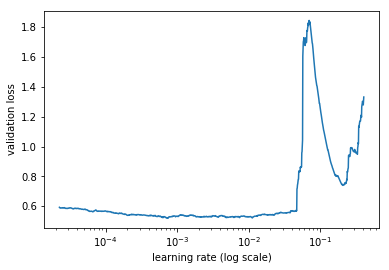

In [222]:
m.lr_find()
m.sched.plot(100)

In [223]:
m.fit(lr, 3)

epoch      trn_loss   val_loss                                  
    0      0.517059   0.380095  
    1      0.504997   0.380051                                  
    2      0.49695    0.380083                                  



[array([0.38008])]

In [224]:
m.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                  
    0      0.496078   0.381011  
    1      0.487899   0.380937                                  
    2      0.492544   0.382105                                  
    3      0.500213   0.381918                                  
    4      0.485711   0.383314                                  



[array([0.38331])]

In [225]:
m.fit(lr, 3, cycle_len=4, cycle_mult=2 )

epoch      trn_loss   val_loss                                  
    0      0.486811   0.38056   
    1      0.484      0.382466                                  
    2      0.460614   0.384003                                  
    3      0.467821   0.384589                                  
    4      0.478948   0.387597                                  
    5      0.470517   0.39337                                   
    6      0.467241   0.390617                                  
    7      0.448035   0.390622                                  
    8      0.461054   0.390144                                  
    9      0.44372    0.391754                                  
    10     0.465959   0.39385                                   
    11     0.438098   0.393193                                  
    12     0.45145    0.394554                                  
    13     0.447818   0.40273                                   
    14     0.444232   0.406923                           

[array([0.4463])]

In [226]:
m.save(modelName)

In [227]:
m.load(modelName)

## Validation

In [228]:
(x,y1)=m.predict_with_targs()

In [229]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted':np.argmax(x,axis=1)
})[['Close','index', 'action','predicted']]
valpred

,Close,index,action,predicted
Timestamp,,,,
2018-06-18 19:40:00,6698.229980,2018-06-18 19:40:00,0,0
2018-06-18 19:41:00,6682.149902,2018-06-18 19:41:00,1,1
2018-06-18 19:42:00,6698.209961,2018-06-18 19:42:00,0,1
2018-06-18 19:43:00,6693.990234,2018-06-18 19:43:00,0,1
2018-06-18 19:44:00,6691.399902,2018-06-18 19:44:00,0,0
2018-06-18 19:45:00,6690.000000,2018-06-18 19:45:00,0,0
2018-06-18 19:46:00,6690.089844,2018-06-18 19:46:00,0,0
2018-06-18 19:47:00,6694.000000,2018-06-18 19:47:00,1,0
2018-06-18 19:48:00,6693.750000,2018-06-18 19:48:00,1,0


Calculate the percent accuracy on the validation set

In [230]:
p.calculate_accuracy(valpred)

{'F1Score': 0.59,
 'totalAccuracy': 0.823,
 'buyAccuracy': 0.257,
 'sellAccuracy': 0.923,
 'totalBuyActions': 855,
 'successfulBuyPredictions': 220}

In [231]:
p.calculate_net_profit(valpred, 15000, 0)
p.result

{'startClose': 6698.23,
 'endClose': 6167.99,
 'startAmount': 15000,
 'endAmount': 14672.269326873095,
 'buyAndHoldPercentIncrease': -7.916,
 'percentIncrease': -2.185,
 'percentDifference': 5.731,
 'totalTrades': 300}

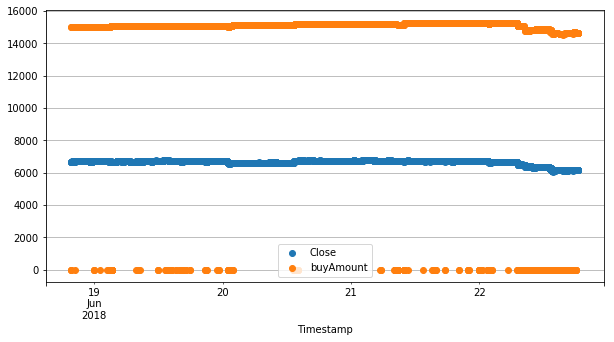

In [232]:
p.plot_profit(p.net_profit_df)

In [233]:
p.net_profit_df

,Timestamp,Close,index,action,predicted,buyAmount,sellAmount
0,2018-06-18 19:40:00,6698.229980,2018-06-18 19:40:00,0,0,15000.000000,0.000000
1,2018-06-18 19:41:00,6682.149902,2018-06-18 19:41:00,1,1,0.000000,2.244787
2,2018-06-18 19:42:00,6698.209961,2018-06-18 19:42:00,0,1,0.000000,2.244787
3,2018-06-18 19:43:00,6693.990234,2018-06-18 19:43:00,0,1,0.000000,2.244787
4,2018-06-18 19:44:00,6691.399902,2018-06-18 19:44:00,0,0,15020.764275,0.000000
5,2018-06-18 19:45:00,6690.000000,2018-06-18 19:45:00,0,0,15020.764275,0.000000
6,2018-06-18 19:46:00,6690.089844,2018-06-18 19:46:00,0,0,15020.764275,0.000000
7,2018-06-18 19:47:00,6694.000000,2018-06-18 19:47:00,1,0,15020.764275,0.000000
8,2018-06-18 19:48:00,6693.750000,2018-06-18 19:48:00,1,0,15020.764275,0.000000
9,2018-06-18 19:49:00,6690.870117,2018-06-18 19:49:00,1,0,15020.764275,0.000000


## Test

In [234]:
np.argmax(m.predict(True), axis =1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0])

In [256]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

In [259]:
p.calculate_accuracy(testPred)

{'F1Score': 0.565,
 'totalAccuracy': 0.559,
 'buyAccuracy': 0.579,
 'sellAccuracy': 0.551,
 'totalBuyActions': 1705,
 'successfulBuyPredictions': 987}

In [260]:
p.calculate_net_profit(testPred, 15000, 0)
p.result

{'startClose': 6167.95,
 'endClose': 6132.99,
 'startAmount': 15000,
 'endAmount': 16558.534328507212,
 'buyAndHoldPercentIncrease': -0.567,
 'percentIncrease': 10.39,
 'percentDifference': 10.957,
 'totalTrades': 1060}

In [238]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-06-22 18:31:00,2018-06-22 18:31:00,6167.950195,1,0,15000.000000,0.000000
2018-06-22 18:32:00,2018-06-22 18:32:00,6167.939941,1,0,15000.000000,0.000000
2018-06-22 18:33:00,2018-06-22 18:33:00,6165.729980,1,0,15000.000000,0.000000
2018-06-22 18:34:00,2018-06-22 18:34:00,6166.000000,1,0,15000.000000,0.000000
2018-06-22 18:35:00,2018-06-22 18:35:00,6165.990234,1,0,15000.000000,0.000000
2018-06-22 18:36:00,2018-06-22 18:36:00,6167.910156,1,0,15000.000000,0.000000
2018-06-22 18:37:00,2018-06-22 18:37:00,6168.000000,1,0,15000.000000,0.000000
2018-06-22 18:38:00,2018-06-22 18:38:00,6170.000000,1,0,15000.000000,0.000000
2018-06-22 18:39:00,2018-06-22 18:39:00,6172.540039,1,0,15000.000000,0.000000


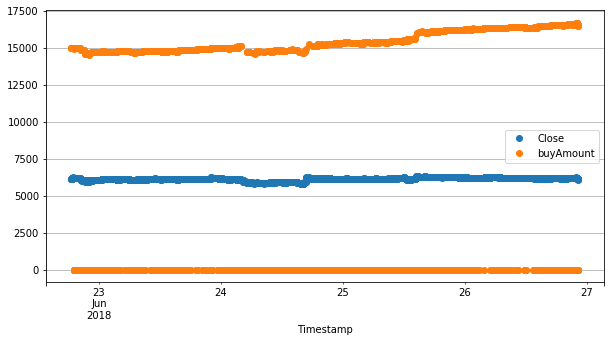

In [239]:
p.plot_profit(p.net_profit_df)

In [240]:
list(p.train.columns.values)

['TimestampYear',
 'TimestampMonth',
 'TimestampWeek',
 'TimestampDay',
 'hour',
 'minute',
 'TimestampDayofweek',
 'TimestampDayofyear',
 'TimestampIs_month_end',
 'TimestampIs_month_start',
 'TimestampIs_quarter_end',
 'TimestampIs_quarter_start',
 'TimestampIs_year_end',
 'TimestampIs_year_start',
 'Open',
 'Close',
 'High',
 'Low',
 'Volume',
 'TimestampElapsed',
 'volume_adi',
 'volume_obv',
 'volume_obvm',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_vpt',
 'volume_nvi',
 'volatility_atr',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbm',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dch',
 'volatility_dcl',
 'volatility_dchi',
 'volatility_dcli',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_adx',
 'trend_adx_pos',
 'trend_adx_neg',
 'trend_adx_ind',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend